## Importing libraries:

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix

import pickle
import os
import warnings
warnings.filterwarnings('ignore')
tqdm().pandas()

## Function 1:
<font size=4>
    <ul>
        <li>This function includes entire pipeline, from data preprocessing to making final predictions.</li>
        <li>Take in raw data as input and returns predictions for the input.</li>
    </ul>
</font>

In [39]:
'''
    This function includes entire pipeline, from data preprocessing to making final predictions
    Take in raw data as input and returns predictions for the input.
'''

def function_1(X):

    # creating dataframe from np array or list
    columns = None
    if not isinstance(X, pd.DataFrame):
        if os.path.isfile('col_lst.pkl'):
            infile = open('col_lst.pkl','rb')
            columns = pickle.load(infile)
            infile.close()
        else:
            print('col_lst pickle file missing!!\n Terminating Process...')
            return
        X = pd.DataFrame(X,columns=columns)
    
    print('Input shape:',X.shape)
    print('='*100)
    
    data=X.copy()
    print('Data preprocessing...')
    
    # replacing -inf and inf to nan
    data.replace([np.inf, -np.inf], np.nan,inplace=True)
    
    print('Checking for null values...')
    nan_col = data.columns[data.isna().any()].tolist()
    print('Columns with null values:\n',nan_col,'\n')
    
    # filling nan values with mean of the column
    for col in nan_col:
        data[col].fillna(data[col].mean(),inplace=True)
    
    # separating columns with constant and categorical features 
    drop_lst = ['Fwd URG Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg',
                'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg',
                'Flow ID', 'Timestamp', 'Unnamed: 0']
       # dropping not required columns

    catfeat=['Fwd PSH Flags', 'Bwd PSH Flags', 'FIN Flag Cnt', 'SYN Flag Cnt',
            'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
            'CWE Flag Count', 'ECE Flag Cnt']
    
    print('Categorical columns:\n',np.array(catfeat),'\n')
    
    print('Dataframe shape before trimming:',data.shape)
    print('\nDropping following columns:\n',np.array(drop_lst))
    data = data.drop(drop_lst,axis=1)
    print('\nDataframe shape after trimming:',data.shape)

    # Feature Engineering for Src and Dst IPs
    print('Feature engineering for Source and Destination IPs...')
    data['Src IP'] = data['Src IP'].progress_apply(lambda x: int(('').join(x.split('.'))))
    data['Dst IP'] = data['Dst IP'].progress_apply(lambda x: int(('').join(x.split('.'))))
    
    # data Normalization
    print('Normalizing data of columns:')
    lst = [i for i in data.columns if i not in catfeat]
    print(np.array(lst))

    scaler = None
    if os.path.isfile('MinMaxScaler.pkl'):
        infile = open('MinMaxScaler.pkl','rb')
        scaler = pickle.load(infile)
        infile.close()
    else:
        print('MinMaxScaler pickle file missing!!\n Terminating Process...')
        return
    
    data = scaler.transform(data)
    
    # loading pretrained model for prediction
    model = None
    if os.path.isfile('ADB.pkl'):
        infile = open('ADB.pkl','rb')
        model = pickle.load(infile)
        infile.close()
    else:
        print('Pre-trained model pickle file missing!! \n Terminating Process...')
        return
    print('\n')
    print('='*100)
    print('Final shape of input data')
    print(data.shape)
    
    print('='*100)
    # predicting y
    print('Predicting labels...')
    ypred = model.predict(data)
    
    return ypred

## Function 2:
<font size=4>
    <ul>
        <li>This function includes entire pipeline, from data preprocessing to returning model metric score</li>
        <li>Take in raw data as input along with its target values and returns binary f1 score.</li>
    </ul>
</font>

In [43]:
'''
    This function includes entire pipeline, from data preprocessing to making final predictions
    take in raw data as input along with its target values and returns binary f1 score.
'''

def function_2(X,Y):
    # label prediction
    y_pred = function_1(X)
    print('predicted label:',y_pred)
    # changing labels into 0 or 1
    y = [0 if i=='Benign' else 1 for i in Y]
    print('='*100)
    print('ytrue:', np.array(y))
    print('='*100)
    return f1_score(y_pred, y)

## Reading csv for function testing:

In [5]:
X = pd.read_csv('unbalaced_20_80_dataset.csv')
columns = X.columns.values
Y = X['Label']
X.drop(['Label'], axis=1, inplace=True)
print(X.shape)
print(Y.shape)

(7616509, 84)
(7616509,)


## Testing the 1st Function

#### Case 1: Predicting multiple data points

In [5]:
y_pred = function_1(X)
print('y_pred shape',y_pred.shape)



Data preprocessing...
Checking for null values...
Columns with null values:
 ['Flow Byts/s', 'Flow Pkts/s'] 

Categorical columns:
 ['Fwd PSH Flags' 'Bwd PSH Flags' 'FIN Flag Cnt' 'SYN Flag Cnt'
 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt' 'URG Flag Cnt'
 'CWE Flag Count' 'ECE Flag Cnt'] 

Dataframe shape before trimming: (7616509, 84)

Dropping following columns:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'
 'Flow ID' 'Timestamp' 'Unnamed: 0']

Dataframe shape after trimming: (7616509, 73)
Feature engineering for Source and Destination IPs...



Normalizing data of columns:
['Src IP' 'Src Port' 'Dst IP' 'Dst Port' 'Protocol' 'Flow Duration'
 'Tot Fwd Pkts' 'Tot Bwd Pkts' 'TotLen Fwd Pkts' 'TotLen Bwd Pkts'
 'Fwd Pkt Len Max' 'Fwd Pkt Len Min' 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std'
 'Bwd Pkt Len Max' 'Bwd Pkt Len Min' 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std'
 'Flow Byts/s' 'Flow Pkts/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max'
 'Fwd IAT Min' 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max'
 'Bwd IAT Min' 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s'
 'Pkt Len Min' 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var'
 'Down/Up Ratio' 'Pkt Size Avg' 'Fwd Seg Size Avg' 'Bwd Seg Size Avg'
 'Subflow Fwd Pkts' 'Subflow Fwd Byts' 'Subflow Bwd Pkts'
 'Subflow Bwd Byts' 'Init Fwd Win Byts' 'Init Bwd Win Byts'
 'Fwd Act Data Pkts' 'Fwd Seg Size Min' 'Active Mean' 'Active Std'
 'Active Max' 'Active Min' 'Idle Mean' 'Idle Std' 'Idle Max' 'Idl

#### Case 2: Predicting single data points

In [41]:
%%time

indx=99999
row = X.iloc[indx].values.reshape(1,-1)
ytrue = Y.iloc[indx]
y_pred = function_1(row)
print('y_pred:',y_pred)
print('ytrue:',ytrue)

Input shape: (1, 84)
Data preprocessing...
Checking for null values...
Columns with null values:
 [] 

Categorical columns:
 ['Fwd PSH Flags' 'Bwd PSH Flags' 'FIN Flag Cnt' 'SYN Flag Cnt'
 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt' 'URG Flag Cnt'
 'CWE Flag Count' 'ECE Flag Cnt'] 

Dataframe shape before trimming: (1, 84)

Dropping following columns:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'
 'Flow ID' 'Timestamp' 'Unnamed: 0']

Dataframe shape after trimming: (1, 73)
Feature engineering for Source and Destination IPs...



Normalizing data of columns:
['Src IP' 'Src Port' 'Dst IP' 'Dst Port' 'Protocol' 'Flow Duration'
 'Tot Fwd Pkts' 'Tot Bwd Pkts' 'TotLen Fwd Pkts' 'TotLen Bwd Pkts'
 'Fwd Pkt Len Max' 'Fwd Pkt Len Min' 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std'
 'Bwd Pkt Len Max' 'Bwd Pkt Len Min' 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std'
 'Flow Byts/s' 'Flow Pkts/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max'
 'Fwd IAT Min' 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max'
 'Bwd IAT Min' 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s'
 'Pkt Len Min' 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var'
 'Down/Up Ratio' 'Pkt Size Avg' 'Fwd Seg Size Avg' 'Bwd Seg Size Avg'
 'Subflow Fwd Pkts' 'Subflow Fwd Byts' 'Subflow Bwd Pkts'
 'Subflow Bwd Byts' 'Init Fwd Win Byts' 'Init Bwd Win Byts'
 'Fwd Act Data Pkts' 'Fwd Seg Size Min' 'Active Mean' 'Active Std'
 'Active Max' 'Active Min' 'Idle Mean' 'Idle Std' 'Idle Max' 'Idl

## Testing the 2nd Function

#### Case 1: Calculating score for multiple data points

In [7]:
score = function_2(X,Y)
print(score)



Data preprocessing...
Checking for null values...
Columns with null values:
 ['Flow Byts/s', 'Flow Pkts/s'] 

Categorical columns:
 ['Fwd PSH Flags' 'Bwd PSH Flags' 'FIN Flag Cnt' 'SYN Flag Cnt'
 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt' 'URG Flag Cnt'
 'CWE Flag Count' 'ECE Flag Cnt'] 

Dataframe shape before trimming: (7616509, 84)

Dropping following columns:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'
 'Flow ID' 'Timestamp' 'Unnamed: 0']

Dataframe shape after trimming: (7616509, 73)
Feature engineering for Source and Destination IPs...



Normalizing data of columns:
['Src IP' 'Src Port' 'Dst IP' 'Dst Port' 'Protocol' 'Flow Duration'
 'Tot Fwd Pkts' 'Tot Bwd Pkts' 'TotLen Fwd Pkts' 'TotLen Bwd Pkts'
 'Fwd Pkt Len Max' 'Fwd Pkt Len Min' 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std'
 'Bwd Pkt Len Max' 'Bwd Pkt Len Min' 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std'
 'Flow Byts/s' 'Flow Pkts/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max'
 'Fwd IAT Min' 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max'
 'Bwd IAT Min' 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s'
 'Pkt Len Min' 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var'
 'Down/Up Ratio' 'Pkt Size Avg' 'Fwd Seg Size Avg' 'Bwd Seg Size Avg'
 'Subflow Fwd Pkts' 'Subflow Fwd Byts' 'Subflow Bwd Pkts'
 'Subflow Bwd Byts' 'Init Fwd Win Byts' 'Init Bwd Win Byts'
 'Fwd Act Data Pkts' 'Fwd Seg Size Min' 'Active Mean' 'Active Std'
 'Active Max' 'Active Min' 'Idle Mean' 'Idle Std' 'Idle Max' 'Idl

#### Case 2: Calculating score for single data points

In [44]:
%%time

indx=1313131
# row = X.iloc[indx].to_frame().transpose()
row = row = X.iloc[indx].values.reshape(1,-1)
ytrue=[]
ytrue.append(Y.iloc[indx])

score = function_2(row, ytrue)
print('f1 score*:',score)

Input shape: (1, 84)
Data preprocessing...
Checking for null values...
Columns with null values:
 [] 

Categorical columns:
 ['Fwd PSH Flags' 'Bwd PSH Flags' 'FIN Flag Cnt' 'SYN Flag Cnt'
 'RST Flag Cnt' 'PSH Flag Cnt' 'ACK Flag Cnt' 'URG Flag Cnt'
 'CWE Flag Count' 'ECE Flag Cnt'] 

Dataframe shape before trimming: (1, 84)

Dropping following columns:
 ['Fwd URG Flags' 'Bwd URG Flags' 'Fwd Byts/b Avg' 'Fwd Pkts/b Avg'
 'Fwd Blk Rate Avg' 'Bwd Byts/b Avg' 'Bwd Pkts/b Avg' 'Bwd Blk Rate Avg'
 'Flow ID' 'Timestamp' 'Unnamed: 0']

Dataframe shape after trimming: (1, 73)
Feature engineering for Source and Destination IPs...



Normalizing data of columns:
['Src IP' 'Src Port' 'Dst IP' 'Dst Port' 'Protocol' 'Flow Duration'
 'Tot Fwd Pkts' 'Tot Bwd Pkts' 'TotLen Fwd Pkts' 'TotLen Bwd Pkts'
 'Fwd Pkt Len Max' 'Fwd Pkt Len Min' 'Fwd Pkt Len Mean' 'Fwd Pkt Len Std'
 'Bwd Pkt Len Max' 'Bwd Pkt Len Min' 'Bwd Pkt Len Mean' 'Bwd Pkt Len Std'
 'Flow Byts/s' 'Flow Pkts/s' 'Flow IAT Mean' 'Flow IAT Std' 'Flow IAT Max'
 'Flow IAT Min' 'Fwd IAT Tot' 'Fwd IAT Mean' 'Fwd IAT Std' 'Fwd IAT Max'
 'Fwd IAT Min' 'Bwd IAT Tot' 'Bwd IAT Mean' 'Bwd IAT Std' 'Bwd IAT Max'
 'Bwd IAT Min' 'Fwd Header Len' 'Bwd Header Len' 'Fwd Pkts/s' 'Bwd Pkts/s'
 'Pkt Len Min' 'Pkt Len Max' 'Pkt Len Mean' 'Pkt Len Std' 'Pkt Len Var'
 'Down/Up Ratio' 'Pkt Size Avg' 'Fwd Seg Size Avg' 'Bwd Seg Size Avg'
 'Subflow Fwd Pkts' 'Subflow Fwd Byts' 'Subflow Bwd Pkts'
 'Subflow Bwd Byts' 'Init Fwd Win Byts' 'Init Bwd Win Byts'
 'Fwd Act Data Pkts' 'Fwd Seg Size Min' 'Active Mean' 'Active Std'
 'Active Max' 'Active Min' 'Idle Mean' 'Idle Std' 'Idle Max' 'Idl

<br>
<br>
<br>
<hr>

## Note:
<hr>
<font size=4>
Since, f1 score is basically the harmonic mean of precision and recall i.e.
</font>

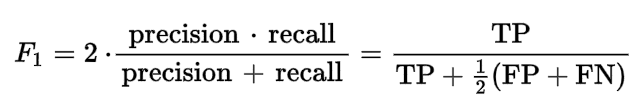

<font size=4>
So, even if True Negative ('Benign' in our case) labels are correctly classified, then also f1_score will be zero(0) because TP, FP and FN all will be zero. Therefore, in above last test case f1 score is zero.
</font>